In [292]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import math
from statistics import median
import scipy.stats as st
cdf = st.norm.cdf
import option_util_V2 as ou
sqrt = math.sqrt
from importlib import reload
import re
import itertools
from multiprocessing import Pool
import multiprocessing
import time
from tqdm.auto import tqdm, trange
from IPython.display import clear_output
clear_output(wait=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.style.use('ggplot')


#from pandas_datareader import data as pdr

packages = {'pd': pd, 'np': np, 'cdf': cdf, 're': re, 'sqrt': sqrt,\
           'itertools': itertools, 'ou': ou}

In [293]:
# Grab Historical Price Data 
stock = yf.Ticker("W")
hist_data = stock.history(period="240mo",
                    interval="1d")

hist_data.tail()

latest_date = hist_data.index.strftime('%Y-%m-%d')[-1]
latest_date

'2020-06-12'

In [294]:

# First get the list of expirations

stock.options

('2020-06-11',
 '2020-06-18',
 '2020-06-25',
 '2020-07-01',
 '2020-07-09',
 '2020-07-16',
 '2020-07-23',
 '2020-07-30',
 '2020-08-20',
 '2020-11-19',
 '2021-01-14',
 '2022-01-20')

In [295]:
# querying calls

exp_date = stock.options[4]  # taking a month out 
opt = stock.option_chain(exp_date)

# calls -- look at the middle (insetad of head/tail)
calls = opt.calls[ (opt.calls['volume'] >= 0) & (opt.calls['openInterest'] >= 0) ]  # vol 15  op 50
inmoneycall = len(calls[ calls['inTheMoney'] == True])
print('exp date: ', exp_date)
calls.iloc[inmoneycall-2:inmoneycall+5]
calls

exp date:  2020-07-09


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
1,W200710C00150000,2020-06-10 18:35:08,150.0,40.49,36.20,40.9,0.000000,0.000000,1.0,7,0.816164,True,REGULAR,USD
3,W200710C00160000,2020-06-10 18:35:08,160.0,32.89,28.60,33.0,0.000000,0.000000,1.0,11,0.794680,True,REGULAR,USD
5,W200710C00165000,2020-06-01 15:44:54,165.0,19.20,24.60,29.0,0.000000,0.000000,6.0,0,0.758791,True,REGULAR,USD
6,W200710C00170000,2020-06-12 19:50:15,170.0,22.50,21.00,24.3,-3.500000,-13.461538,15.0,2,0.706119,True,REGULAR,USD
7,W200710C00172500,2020-06-12 19:50:15,172.5,20.90,19.20,23.3,4.199999,25.149693,15.0,10,0.712893,True,REGULAR,USD
8,W200710C00175000,2020-06-10 17:47:19,175.0,21.67,17.70,21.8,0.000000,0.000000,5.0,13,0.710452,True,REGULAR,USD
9,W200710C00177500,2020-06-11 13:32:59,177.5,15.60,16.50,20.4,0.000000,0.000000,1.0,5,0.714725,True,REGULAR,USD
10,W200710C00180000,2020-06-11 13:53:12,180.0,15.20,15.00,18.8,0.000000,0.000000,2.0,4,0.703006,True,REGULAR,USD
11,W200710C00182500,2020-06-10 19:42:06,182.5,16.30,14.20,18.4,0.000000,0.000000,6.0,5,0.734622,True,REGULAR,USD
12,W200710C00185000,2020-06-12 18:47:14,185.0,12.70,12.50,16.4,0.000000,0.000000,2.0,29,0.701907,False,REGULAR,USD


In [296]:
# PUTS

# Puts with min volume & interest
puts = opt.puts[ (opt.puts['volume'] >= 0) & (opt.puts['openInterest'] >= 0) ]   # vol 15 op 50

# 
inmoneyput = len(puts[puts['inTheMoney']==False])
puts.iloc[inmoneyput-5:inmoneyput+2]


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
14,W200710P00165000,2020-06-12 16:43:09,165.0,9.50,5.8,7.6,2.000000,26.666666,7.0,10,0.738772,False,REGULAR,USD
16,W200710P00170000,2020-06-11 15:49:40,170.0,10.02,8.5,11.1,0.000000,0.000000,12.0,17,0.810183,False,REGULAR,USD
17,W200710P00172500,2020-06-12 13:39:03,172.5,10.30,7.4,11.5,0.300000,3.000002,1.0,7,0.737307,False,REGULAR,USD
18,W200710P00175000,2020-06-12 19:20:35,175.0,12.72,8.5,13.0,-0.099999,-0.780027,2.0,17,0.749636,False,REGULAR,USD
21,W200710P00182500,2020-06-12 13:36:25,182.5,15.00,12.2,16.4,-3.400000,-18.478260,4.0,5,0.747378,False,REGULAR,USD
22,W200710P00185000,2020-06-12 14:16:35,185.0,16.90,13.0,17.5,-2.600000,-13.333335,1.0,16,0.729068,True,REGULAR,USD
23,W200710P00187500,2020-06-12 17:17:26,187.5,20.40,14.3,18.5,-0.200001,-0.970877,2.0,5,0.717471,True,REGULAR,USD



# Manual Options Analysis (Optimizer is built on this process) 


In [297]:
# Single Output Inputs

exp_date = exp_date
#exp_date = stock.options[4]  # grabbing the option end date 1 month out 

# CALL AND PUT INPUTS -- FLOATS ONLY -- input None if no option -> e.g. sell_call = None
buy_call_strike =  180 # 315.0
buy_put_strike = 170 # 315.0
sell_call_strike = 190 #317.5 # 325.0
sell_put_strike = 160 # 305.0 # = None

opt_strikes = [buy_call_strike, buy_put_strike, sell_call_strike, sell_put_strike]

# CURRENT PRICE

current_price = hist_data['Close'].tail(1)[0]

# Price percent range to look at
perc_range, increments = .40, .02

print('current price: '+str(current_price))
print('exp date: '+str(exp_date))


# Live Market Data for options

live = input('What Price Do You Want? 0 Worst Bid/Ask; 1 LastTradedPrice; 2 Mid Bid/Ask:  ')

current price: 184.76
exp date: 2020-07-09
What Price Do You Want? 0 Worst Bid/Ask; 1 LastTradedPrice; 2 Mid Bid/Ask:  0


## Standard Deviation of the Stock Returns & Price

In [298]:
# Getting STD (from another file)

stock_data, final_ret_std, mthly_ret_std, price_std_pct, price_std = ou.get_std(hist_data, 20, exp_date) # days for STD

# Stock_data, std = io.get_std(hist_data, 15, 20, sqrt) 
# Takes: DF  \  STD over X days \ sqrt function
# Returns: DF \ STD of returns (over Y period) over last X days

print('final STD: ', round(final_ret_std,4))   # this is the avg daily chg
print('mythly_ret_std: ', round(mthly_ret_std,4))
print('price_std_pct: ', round(price_std_pct,4))
print('price_std: ', round(price_std,4))

final STD:  0.0505
mythly_ret_std:  0.2199
price_std_pct:  0.0628
price_std:  10.2835


## Grab Price Data and Calculate Table of Outcomes based on Probabilities

In [299]:
# Get Option Price Data

opt_prices = ou.opt_price_data(opt, live, opt_strikes)

print('option strikes:', opt_strikes[0], opt_strikes[1], opt_strikes[2], \
        opt_strikes[3], '-buy call, buy put, sell call, sell put')
print('option prices:', opt_prices[0], opt_prices[1], opt_prices[2], opt_prices[3])
#print('options prices: ', buy_call_price, buy_put_price, sell_call_price, sell_put_price)


# Create Table of Hypothetical Prices with probabilities

##### right now STD range is based on current_price, you can add price pred here

df = ou.options_outcomes(perc_range, increments, \
                         current_price, current_price # future pred price here
                         , mthly_ret_std, opt_strikes, opt_prices)

df

option strikes: 180 170 190 160 -buy call, buy put, sell call, sell put
option prices: 18.8 11.1 10.0 3.6


,prices,price_perc,z-score,prob,prob_pct,buy_call_180,buy_put_170,sell_call_190,sell_put_160,profit_loss,exp_profit_loss
0,110.86,-0.40,1.818558,0.0690,0.004052,-1880.0,4804.0,1000.0,-4554.0,-630.0,-2.552854
1,114.55,-0.38,1.727753,0.0840,0.004933,-1880.0,4435.0,1000.0,-4185.0,-630.0,-3.107822
2,118.25,-0.36,1.636702,0.1016,0.005967,-1880.0,4065.0,1000.0,-3815.0,-630.0,-3.758985
3,121.94,-0.34,1.545897,0.1222,0.007176,-1880.0,3696.0,1000.0,-3446.0,-630.0,-4.521142
4,125.64,-0.32,1.454846,0.1458,0.008562,-1880.0,3326.0,1000.0,-3076.0,-630.0,-5.394292
5,129.33,-0.30,1.364042,0.1726,0.010136,-1880.0,2957.0,1000.0,-2707.0,-630.0,-6.385835
6,133.03,-0.28,1.272991,0.2030,0.011922,-1880.0,2587.0,1000.0,-2337.0,-630.0,-7.510571
7,136.72,-0.26,1.182186,0.2372,0.013930,-1880.0,2218.0,1000.0,-1968.0,-630.0,-8.775899
8,140.42,-0.24,1.091135,0.2752,0.016162,-1880.0,1848.0,1000.0,-1598.0,-630.0,-10.181818
9,144.11,-0.22,1.000330,0.3172,0.018628,-1880.0,1479.0,1000.0,-1229.0,-630.0,-11.735729


## Risk/Return Analysis

In [300]:
# Perform Risk Calculations

std_for_var = .5

option_combo = ou.risk_analysis(df, opt_strikes, opt_prices, std_for_var, exp_date, stock.ticker)

option_combo


,stock,exp_date,buy_call,buy_put,sell_call,sell_put,cost,exp_profit,risk_spread,bull_bear,var_std_0.5,max_loss,max_profit,risk_ratio_95th,odds_profit,odds_loss,median_profit,median_loss,buy_call_price,buy_put_price,sell_call_price,sell_put_price,current_value,head_profit,tail_profit
0,W,2020-07-09,180 | 18.8,170 | 11.1,190 | 10.0,160 | 3.6,1630.0,-21.68,0.8,0.0,-944.0,-1630.0,-630.0,-0.39,0.0,1.0,NaN,-630.0,18.8,11.1,10.0,3.6,-1154.0,-630.0,-630.0


# Optimizer

In [302]:
# Gather Stock Data 
stock_list = ['W', 'AMD', 'HAL', 'BAC', 'AMC', 'CZR', 'GE', 'TWTR', 'GME', 'SLB', \
              'JBLU','MGM','BBBY', 'UBER', 'LYFT', 'M', 'ACB', 'BABA', 'SQ', 'WORK', \
              'DAL', 'CCL', 'WFC', 'HTZ', 'BA', 'AAL', 'CAR']

stock_dict_final = ou.get_stock_data(stock_list)    # only run this once per day

In [303]:
# Data Check

#stock_dict_final['AMD']['ticker']
#stock_dict_final['CZR']['options']
#stock_dict_final['AMD']['hist_data'].head()
stock_dict_final['WORK']['option_chain']['2020-07-16']['puts'].head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,WORK200717P00003000,2020-04-14 15:00:19,3.0,0.10,NaN,0.1,0.0,0.0,50.0,60,3.828125,False,REGULAR,USD
1,WORK200717P00008000,2020-05-26 13:30:08,8.0,0.05,0.0,0.2,0.0,0.0,30.0,36,2.203129,False,REGULAR,USD
2,WORK200717P00010000,2020-05-14 15:39:21,10.0,0.10,0.0,0.2,0.0,0.0,1.0,0,1.855469,False,REGULAR,USD
3,WORK200717P00013000,2020-05-14 13:30:09,13.0,0.05,0.0,0.2,0.0,0.0,10.0,76,1.453128,False,REGULAR,USD
4,WORK200717P00014000,2020-06-08 13:30:09,14.0,0.05,0.0,0.2,0.0,0.0,200.0,749,1.339847,False,REGULAR,USD


In [304]:
# OPTIMIZER V2 - INPUTS FUNCTION

def opt_inputs(opt_ticker, max_permutations, strategy_list, live): 

    optimizer_stock = stock_dict_final[opt_ticker] 

    inputs = {
     'max_permutations': max_permutations  # 0 means no cap. This is Max Permutations per STRATEGY
    ,'exp_datelist': ou.date_filter(optimizer_stock['options'],4,26) # min wks out, max wks out 
    ,'strategy_list': strategy_list #,'bear_put','bull_call']  # ['bear_put', 'bull_call', 'strangle', 'ric'] (reverse IronCondor). # list for multiple 

    ,'live': live 
    ,'past_time': 20           # time period to base STD, in business days
    ,'perc_range': 1.0      # for simulating hypothetical outcomes
    ,'increments': .01
    ,'std_for_var': .5     # will calculate average profit/loss at specified point std
    ,'volume': np.where(live=='1',0,15)                # min volume       (15)
    ,'openInterest': np.where(live=='1',0,50)          # min open interest (50)
    ,'stock': optimizer_stock
    ,'option_chain': optimizer_stock['option_chain']
    ,'ticker': optimizer_stock['ticker']
    ,'hist_data': optimizer_stock['hist_data']
    ,'current_price': optimizer_stock['hist_data']['Close'].tail(1)[0]
    }
    return inputs 

In [305]:
# MULTI PROCESSING FUNCTION

def multi_proc(inputs, current_time):
    #current_time = datetime.now().strftime('%Y-%m-%d_%H-%M')

    ticker = inputs['ticker']

    # Generate Permutations & STD data
    combos, std_data, exp_dict = ou.ric_permutations3(inputs)  # V3 is multiple strategies   # V2 is RIC only
    combo_list = np.array(combos.values.tolist())

    # Multiprocessing -- Creating smaller blocks, feed in and loop through multi processing
    stock_output = pd.DataFrame()
    if __name__ == '__main__':
        block_size = 50000  # 50000

        for i in range(math.ceil(len(combo_list)/block_size)):
            clear_output()
            combo_block = combo_list[i*block_size:(i*block_size+block_size)]
            final_values = []
            print('\nStock: ', ticker, '      Permutations: ', len(combo_list), '       Start Time: ', current_time)
            print('\nNumber of Expiry Dates: ', len(exp_dict),'\n',exp_dict)
            print('\nBlock:  ' + str(i+1)+' of  '+str(math.ceil(len(combo_list)/block_size)) + '    Block Start: '+\
                   str(i*block_size), end=' ')
            with Pool(7) as p:
                final_values = list(tqdm(p.imap(ou.stock_optimizer1, [ [combo_block[x], std_data, inputs] \
                            for x in range(len(combo_block)) ] ) , total=len(combo_block)))
            p.close()
            p.terminate()
        # list comprehension optimizer
            #final_array = np.array([ ou.stock_optimizer1( [combo_list[i], std_data, inputs] ) for i in range(len(combo_list)) ])

    #Processing Results
            block_output = pd.DataFrame( (i[0][0] for i in final_values) , columns = final_values[0][1])
            stock_output = stock_output.append(block_output, ignore_index=True)

    # Adding weighted score
    try:
        stock_output = ou.ric_score(stock_output)
    except KeyError:
        pass

    stock_output.head(50000).to_csv(rf'Output\{ticker}_{current_time}.csv')
    return stock_output

### Run the Optimizer!

In [310]:
np.random.randn(5,3)

array([[ 0.7302575 , -0.48881599, -0.32253523],
       [-1.13020598, -1.0527628 ,  1.03309025],
       [-0.74528653, -0.48271968, -1.13489514],
       [-0.7102596 , -0.53304192, -2.30526525],
       [-1.25849928, -0.36895337,  0.92375725]])

In [312]:
df = pd.DataFrame( np.random.randn(2,3), columns = ['a', 'b', 'c'] )

df

,a,b,c
0,-0.255608,-0.389981,-0.140361
1,1.244040,0.769809,0.450941


In [314]:
df[['b','c']] = df[['a','b']]

df

,a,b,c
0,-0.255608,-0.255608,-0.389981
1,1.244040,1.244040,0.769809


In [330]:
type(df['a'].iloc[0])

numpy.float64

In [332]:
if type(df['a'].iloc[0]) == np.float64:
    print(0)

0


In [402]:
reload(ou)

<module 'option_util_V2' from 'G:\\Python_Projects\\01_StockMarketProjects\\option_util_V2.py'>

In [421]:
# Inputs
#['W','AMD','HAL', 'BAC', 'AMC', 'CZR', 'GE', 'TWTR', 'GME', 'SLB', \
#              'JBLU', 'MGM', 'BBBY', 'UBER', 'LYFT', 'M', 'ACB', 'BABA', 'SQ', 'WORK', \
#              'DAL', 'CCL', 'WFC', 'HTZ', 'BA', 'AAL', 'CAR']

max_permutations = 50000 # per strategy, up to 4 strategies per stock. e.g. 10 stocks

opt_stock_list = ['W', 'AMD','HAL', 'BAC', 'CZR', 'GE', 'TWTR', 'GME', 'SLB', \
              'JBLU', 'MGM', 'UBER', 'LYFT', 'M', 'ACB', 'BABA', 'SQ', 'WORK', \
              'DAL', 'CCL', 'WFC', 'HTZ', 'BA', 'CAR']

strategy_list = ['ric', 'bear_put','bull_call','strangle']   # ric, bear_put, bull_call, strangle
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
live = input('\nWhat Price Do You Want? 0 Worst Bid/Ask; 1 LastTradedPrice; 2 Mid Bid/Ask:  ')
final_output = pd.DataFrame()

for i in range(len(opt_stock_list)):
    inputs = opt_inputs(opt_stock_list[i],max_permutations, strategy_list, live)
    final_output = final_output.append(multi_proc(inputs,current_time))
final_output = final_output.sort_values('score', ascending=False).reset_index(drop=True)

final_output = ou.ric_score(final_output)
final_output.to_csv(rf'Output\final_output_{current_time}.csv')

final_output.head(5)


Stock:  CAR       Permutations:  5680        Start Time:  2020-06-12_15-17

Number of Expiry Dates:  3 
 {'2020-07-16': 5134.0, '2020-08-20': 545.0, '2020-11-19': 1.0}

Block:  1 of  1    Block Start: 0 

,stock,exp_date,strategy,price,buy_call,buy_put,sell_call,sell_put,cost,exp_profit,risk_spread,odds_profit,odds_loss,max_loss,max_profit,risk_ratio_95th,median_profit,median_loss,bull_bear,var_std_0.5,buy_call_price,buy_put_price,sell_call_price,sell_put_price,current_value,head_profit,tail_profit,min_leg_profit,buy_call_vol,buy_put_vol,sell_call_vol,sell_put_vol,score,buy_call_strike,buy_put_strike,sell_call_strike,sell_put_strike
0,BABA,2020-07-16,strangle,217.64,260.0 | 0.34,240.0 | 24.1,None | 0.0,None | 0.0,2444.0,0.04,0.30,0.48,0.52,-2444.0,21556.0,1.3,9179.5,-1731.0,-0.47,-208.0,0.34,24.1,0.0,0.0,-208.0,21556.0,15084.0,15084.0,21.0 | 1365,52.0 | 1626,0.0 | 0,0.0 | 0,0.686774,260.0,240.0,None,None
1,BABA,2020-07-16,strangle,217.64,265.0 | 0.25,240.0 | 24.1,None | 0.0,None | 0.0,2435.0,0.02,0.32,0.48,0.52,-2435.0,21565.0,1.3,9047.0,-1940.0,-0.47,-199.0,0.25,24.1,0.0,0.0,-199.0,21565.0,14593.0,14593.0,262.0 | 1814,52.0 | 1626,0.0 | 0,0.0 | 0,0.685194,265.0,240.0,None,None
2,BABA,2020-07-16,strangle,217.64,270.0 | 0.17,240.0 | 24.1,None | 0.0,None | 0.0,2427.0,0.02,0.35,0.48,0.52,-2427.0,21573.0,1.3,8950.0,-1968.0,-0.47,-191.0,0.17,24.1,0.0,0.0,-191.0,21573.0,14101.0,14101.0,57.0 | 1254,52.0 | 1626,0.0 | 0,0.0 | 0,0.684297,270.0,240.0,None,None
3,BABA,2020-07-23,strangle,217.64,265.0 | 0.51,255.0 | 38.6,None | 0.0,None | 0.0,3911.0,-0.33,0.39,0.48,0.52,-3911.0,21589.0,1.3,8748.0,-2234.5,-0.48,-175.0,0.51,38.6,0.0,0.0,-175.0,21589.0,13117.0,13117.0,15.0 | 160,1062.0 | 726,0.0 | 0,0.0 | 0,0.676207,265.0,255.0,None,None
4,BABA,2020-07-16,strangle,217.64,290.0 | 0.08,240.0 | 24.1,None | 0.0,None | 0.0,2418.0,0.01,0.44,0.47,0.53,-2418.0,21582.0,1.3,8467.0,-2418.0,-0.47,-182.0,0.08,24.1,0.0,0.0,-182.0,21582.0,12110.0,12110.0,50.0 | 504,52.0 | 1626,0.0 | 0,0.0 | 0,0.674499,290.0,240.0,None,None


In [600]:
reload(ou)

<module 'option_util_V2' from 'G:\\Python_Projects\\01_StockMarketProjects\\option_util_V2.py'>

In [601]:
final_output = ou.ric_score(final_output)


## Manual Deep Dive - For Use After Optimizer Run

In [602]:
#final_output = pd.read_csv(r"Output\final_output_2020-06-08_14-40.csv")   # reload output if kernal lost data
#final_output = final_output.sort_values('score', ascending=False).reset_index(drop = True)

final_output1 = final_output.reset_index()
final_output1.groupby('stock')['index'].min().sort_values(ascending=True)  # rooting out the best stocks

stock
BABA         0
BAC        472
WFC        511
ACB        544
GE         586
WORK      1089
DAL       1688
TWTR      1796
BA        2037
HAL       2828
MGM       3125
AMD       4276
CAR       4747
CCL       5577
JBLU      5808
M         5983
SLB       6906
LYFT      8022
SQ        8424
UBER     11835
W        24621
CZR      25962
GME      34697
HTZ     169659
Name: index, dtype: int64

In [604]:
# Drilling Down into the Final Output

final_output[ (final_output['cost'] < 500) & (final_output['risk_ratio_95th'] >= .5) & \
                    (final_output['exp_profit'] > -.1) &  \
                     (final_output['risk_spread'] < .4) & \
                     ~(final_output['stock'].isin(['BAC'])) & \
                     (final_output['stock'].isin(['BA','MGM','CZR','HTZ'])) & \
                     (pd.to_numeric(final_output['bull_bear']).between(-.1,.1)) & \
                     (final_output['odds_profit'] > .45) \
                     ].head(15).sort_values('risk_spread', ascending=True)

final_output[ final_output['stock'].isin(['WORK']) & (final_output['bull_bear'].between(-1,.1))].head(15)

#final_output.head(100)
#final_output[ (final_output['cost'] < 200) & (final_output['sell_put_strike'] < final_output['buy_put_strike']) &\
#                                   (final_output['buy_put_strike'] < final_output['price'] ) & \
#                                    (final_output['buy_call_strike'] > final_output['price']) \
#                                    
#                                    ].sort_values('score', ascending=False).head(10) 


# remove RIC where intrinsic value doesn't equal max loss

,stock,exp_date,strategy,price,buy_call,buy_put,sell_call,sell_put,cost,exp_profit,risk_spread,odds_profit,odds_loss,max_loss,max_profit,risk_ratio_95th,median_profit,median_loss,bull_bear,var_std_0.5,buy_call_price,buy_put_price,sell_call_price,sell_put_price,current_value,head_profit,tail_profit,min_leg_profit,buy_call_vol,buy_put_vol,sell_call_vol,sell_put_vol,score,buy_call_strike,buy_put_strike,sell_call_strike,sell_put_strike
2321,WORK,2020-07-16,ric,30.86,31.0 | 2.65,29.0 | 1.9,40.0 | 0.55,20.0 | 0.05,395.0,-0.19,0.31,0.40,0.6,-395.0,505.0,1.28,505.0,-248.5,0.07,-125.0,2.65,1.9,0.55,0.05,-395.0,505.0,505.0,505.0,627.0 | 1439,69.0 | 720,1344.0 | 9939,23.0 | 1886,0.769784,31.0,29.0,40.0,20.0
2356,WORK,2020-07-16,ric,30.86,32.0 | 2.25,27.0 | 1.15,38.0 | 0.75,20.0 | 0.05,260.0,-0.13,0.32,0.39,0.61,-260.0,440.0,1.30,340.0,-251.0,0.10,-132.0,2.25,1.15,0.75,0.05,-260.0,440.0,340.0,340.0,1768.0 | 14909,103.0 | 2540,352.0 | 2295,23.0 | 1886,0.769586,32.0,27.0,38.0,20.0
2508,WORK,2020-07-16,ric,30.86,32.0 | 2.25,28.0 | 1.5,39.0 | 0.65,20.0 | 0.05,305.0,-0.17,0.32,0.39,0.61,-305.0,495.0,1.30,395.0,-252.0,0.08,-135.0,2.25,1.5,0.65,0.05,-305.0,495.0,395.0,395.0,1768.0 | 14909,10120.0 | 11614,92.0 | 1386,23.0 | 1886,0.768875,32.0,28.0,39.0,20.0
2545,WORK,2020-07-16,ric,30.86,32.0 | 2.25,28.0 | 1.5,40.0 | 0.55,20.0 | 0.05,315.0,-0.18,0.32,0.39,0.61,-315.0,485.0,1.30,485.0,-262.0,0.08,-145.0,2.25,1.5,0.55,0.05,-315.0,485.0,485.0,485.0,1768.0 | 14909,10120.0 | 11614,1344.0 | 9939,23.0 | 1886,0.768697,32.0,28.0,40.0,20.0
3316,WORK,2020-07-16,ric,30.86,32.0 | 2.25,30.0 | 2.3,42.0 | 0.4,20.0 | 0.05,410.0,-0.23,0.32,0.38,0.62,-410.0,590.0,1.30,590.0,-249.0,0.00,-140.0,2.25,2.3,0.4,0.05,-410.0,590.0,590.0,590.0,1768.0 | 14909,10345.0 | 14003,283.0 | 728,23.0 | 1886,0.765231,32.0,30.0,42.0,20.0
4059,WORK,2020-07-16,ric,30.86,32.0 | 2.25,28.0 | 1.5,42.0 | 0.4,20.0 | 0.05,330.0,-0.20,0.33,0.37,0.63,-330.0,670.0,1.30,470.0,-268.0,0.06,-160.0,2.25,1.5,0.4,0.05,-330.0,470.0,670.0,470.0,1768.0 | 14909,10120.0 | 11614,283.0 | 728,23.0 | 1886,0.761892,32.0,28.0,42.0,20.0
4227,WORK,2020-07-16,ric,30.86,32.0 | 2.25,29.0 | 1.9,42.0 | 0.4,20.0 | 0.05,370.0,-0.23,0.33,0.37,0.63,-370.0,630.0,1.30,530.0,-257.5,0.04,-150.0,2.25,1.9,0.4,0.05,-370.0,530.0,630.0,530.0,1768.0 | 14909,69.0 | 720,283.0 | 728,23.0 | 1886,0.761359,32.0,29.0,42.0,20.0
4409,WORK,2020-07-16,ric,30.86,32.0 | 2.25,30.0 | 2.3,45.0 | 0.25,20.0 | 0.05,425.0,-0.27,0.33,0.37,0.63,-425.0,875.0,1.30,575.0,-262.5,-0.01,-155.0,2.25,2.3,0.25,0.05,-425.0,575.0,875.0,575.0,1768.0 | 14909,10345.0 | 14003,543.0 | 4340,23.0 | 1886,0.760647,32.0,30.0,45.0,20.0
4465,WORK,2020-07-16,ric,30.86,32.0 | 2.25,30.0 | 2.3,44.0 | 0.25,20.0 | 0.05,425.0,-0.28,0.33,0.37,0.63,-425.0,775.0,1.30,575.0,-262.5,-0.01,-155.0,2.25,2.3,0.25,0.05,-425.0,575.0,775.0,575.0,1768.0 | 14909,10345.0 | 14003,38.0 | 225,23.0 | 1886,0.760470,32.0,30.0,44.0,20.0
4561,WORK,2020-07-16,ric,30.86,32.0 | 2.25,30.0 | 2.3,50.0 | 0.15,20.0 | 0.05,435.0,-0.30,0.33,0.37,0.63,-435.0,1365.0,1.30,565.0,-272.5,-0.01,-165.0,2.25,2.3,0.15,0.05,-435.0,565.0,1365.0,565.0,1768.0 | 14909,10345.0 | 14003,157.0 | 3533,23.0 | 1886,0.760114,32.0,30.0,50.0,20.0


### Manual Drill Down -- choose the index you want to look into

In [605]:
# Options Info
index_num = 2321

#5512 bought

final_output['head_profit'].values

dd = final_output.iloc[[index_num]]
exp_deep_dive = dd['exp_date'].values[0] #'2020-09-17'
stock_dd = dd['stock'].values[0] #'2020-09-17'
tmp_strikes = [dd['buy_call'].values[0].split()[0], dd['buy_put'].values[0].split()[0],\
                  dd['sell_call'].values[0].split()[0], dd['sell_put'].values[0].split()[0] ]
    
opt_strikes_dd = [ None if x == 'None' else float(x) for x in tmp_strikes ]

            
opt_dd = stock_dict_final[f'{stock_dd}']['option_chain'][exp_deep_dive]
opt_info = pd.concat( [opt_dd['calls'][opt_dd['calls']['strike'] == opt_strikes_dd[0]], \
                       opt_dd['puts'][opt_dd['puts']['strike'] == opt_strikes_dd[1]], \
                        opt_dd['calls'][opt_dd['calls']['strike'] == opt_strikes_dd[2]], \
                         opt_dd['puts'][opt_dd['puts']['strike'] == opt_strikes_dd[3]] ] )
#opt_info


# DF Table Deep Dive

increments_test = .02 #  to match out to output choose .01
current_price = stock_dict_final[f'{stock_dd}']['hist_data']['Close'].tail(1)[0]

stock_data_dd, final_ret_std_dd, mthly_ret_std_dd, price_std_pct_dd, price_std_dd = \
                ou.get_std(stock_dict_final[f'{stock_dd}']['hist_data'], inputs['past_time'], exp_deep_dive) # days for STD

opt_prices_dd = ou.opt_price_data(opt_dd, inputs['live'], opt_strikes_dd)
df_test = ou.options_outcomes(3, increments_test, \
                        current_price, current_price, # future pred price here \
                         mthly_ret_std_dd, opt_strikes_dd, opt_prices_dd)

df_test = df_test[ (df_test['prices'] > 0) & (df_test['price_perc'] < .7)]



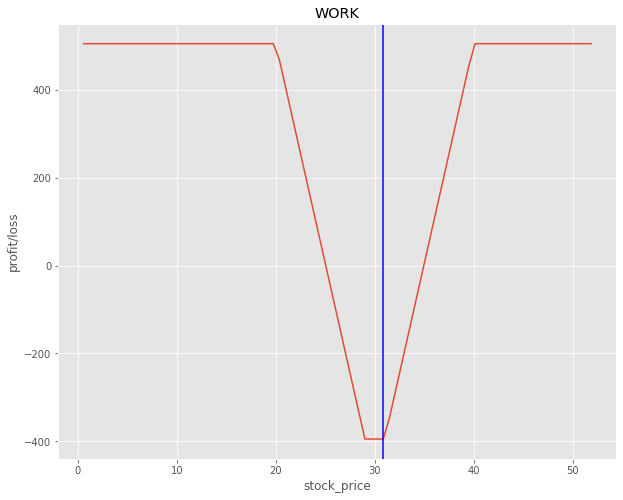

In [606]:

# Plotting the results

series_test = df_test['profit_loss']
series_test = series_test.rename(df_test['prices']) # set index label to stock price

plt.figure(figsize=(10,8))
plt.plot(series_test)
plt.xlabel('stock_price')
plt.ylabel('profit/loss')
plt.title(final_output['stock'].iloc[[index_num]].values[0])

plt.axvline(df_test[ df_test['price_perc'] == 0]['prices'].values, color='blue', label='current_price')

plt.show()

In [541]:
# Table

df_test.head(90)

,prices,price_perc,z-score,prob,prob_pct,buy_call_32.0,buy_put_26.0,sell_call_37.0,sell_put_21.0,profit_loss,exp_profit_loss
101,0.61,-0.98,2.559827,0.0104,0.000340,-320.0,2350.0,158.0,-1969.0,219.0,0.074552
102,1.22,-0.96,2.507463,0.0122,0.000399,-320.0,2289.0,158.0,-1908.0,219.0,0.087455
103,1.83,-0.94,2.455099,0.0140,0.000458,-320.0,2228.0,158.0,-1847.0,219.0,0.100358
104,2.43,-0.92,2.403593,0.0162,0.000530,-320.0,2168.0,158.0,-1787.0,219.0,0.116129
105,3.04,-0.90,2.351229,0.0188,0.000615,-320.0,2107.0,158.0,-1726.0,219.0,0.134767
106,3.65,-0.88,2.298865,0.0216,0.000707,-320.0,2046.0,158.0,-1665.0,219.0,0.154838
107,4.26,-0.86,2.246501,0.0246,0.000805,-320.0,1985.0,158.0,-1604.0,219.0,0.176344
108,4.87,-0.84,2.194137,0.0282,0.000923,-320.0,1924.0,158.0,-1543.0,219.0,0.202150
109,5.48,-0.82,2.141773,0.0322,0.001054,-320.0,1863.0,158.0,-1482.0,219.0,0.230824
110,6.09,-0.80,2.089409,0.0366,0.001198,-320.0,1802.0,158.0,-1421.0,219.0,0.262365


In [148]:

std_for_var = .5

option_combo = ou.risk_analysis(df_test, opt_strikes_dd, opt_prices_dd, std_for_var, exp_deep_dive)

option_combo

,exp_date,buy_call,buy_put,sell_call,sell_put,expected_profit,risk_spread,bull_bear,var_std_0.5,max_loss,max_profit,risk_ratio_95th,odds_profit,odds_loss,median_profit,median_loss,buy_call_price,buy_put_price,sell_call_price,sell_put_price
0,2020-06-25,385.0 | 0.08,300.0 | 3.75,390.0 | 0.02,297.5 | 3.05,-1.32,0.28,-0.12,-76.0,-76.0,424.0,3.0,0.12,0.88,174.0,-76.0,0.08,3.75,0.02,3.05


## Next Steps


0. show options volume & open interest in output

1. Build in several options strategies - DONE 
    - keep same function but pass in a variable in PERMUTATIONS, RISK ANALYSIS that tailors to that options strategy
            - how is options_outcomes affected by NULL data?
        - RIC
        - Bear Put
        - Bull Call
        - Straddle

2. Pattern matching --
    - 30 day time periods. track return % from Day 1
    - Match up returns. Least distance. day 1, day 2, lowest mse
    - Match up 3 weeks. Then predict week 4
    - Variable 1: hist date range (max 5 - 10 years)
    - Variable 2: 30 day time period (45? 60?)
    - Variable 3: Future prediction range
    - Variable 4: Num to use for avg. Do a weighted avg? 
           - try normalizing returns with a min & max approach

3. Black Scholes pricing model - https://aaronschlegel.me/black-scholes-formula-python.html
    - check out pyfin. has multiple options pricing functions
    
4. Stock price predictive model
    - full list of methods is below
5. Stock Picker
    -Stocks with highest VOL 
    -Stocks with a recent huge drawdown
    -Stocks with high options volume
    -Stocks that have broken above a trading range
6. Volatility predictor 
    - how does volatility change over time
7. Stocks Price Predictor with Best Options
    - Algo that predicts future stock price for top 50 stocks
        - Highest Options Volume
        - High volatility
    - Then provides best Options to choose given that future price prediction
8. Pick Stocks for retirement account
    - Value stocks (p/e or whatever)
    - Good growth
    - Smaller market caps 



## Building Options Model

### Picking a stock ideas
 - rising volatility improves options
     - use options table to find stock w/ largest IV
 - you'll then want to rotate through top stocks and spit out best options
 - Stocks dropping in value have higher volatility
 - Predict stock price moving average 30 days out and wrap volatility around that
 


## Predict Stock Direction using:
     
     - Find highly correlated stocks. If one most more than the other. buy the lagger & short the leader. (simons strategy)
     - Markov Model 
     - RSI
     - MA
     - EMA
     - Logistic Regression
     - Linear Regression
     - SVM
     - Random Forrest
     - Gradient Boosting
     - Prophet (separate notebook)
     - LSTM https://github.com/kartik-joshi/Stock-predection  
     - Back Propogation
     - Detect technical chart patterns: https://medium.com/automation-generation/algorithmically-detecting-and-trading-technical-chart-patterns-with-python-c577b3a396ed
                        - https://pythonprogramming.net/average-outcomes-as-predictions-forex-hft/?completed=/predicting-from-patterns/
         - Culmination of all of these strategies. pick majority. or just regression to get highest R2's and weight. 


https://medium.com/datadriveninvestor/predicting-stock-prices-comparison-of-different-algorithms-ab2b8fd42514

## Predict Price Movement (volatility) -- not direction:
     - hypothesis: stocks get more volatile as they drop. predict realized volatility based on 30 day prior price movement. what % up or down works best. 
     - RSI
     - MA - separation from avg could be a predictor
     - EMA
     - Logistic Regression
     - Linear Regression
     - SVM
     - Random Forrest
     - Gradient Boosting
     - Prophet (separate notebook)


In [22]:
# Do i look at std from last value or from the MA???

# reversion to the mean may or may not be a real deal
    # you can look at predicted values based on last value vs MA
    # throw a single STD around each and calc which one is more accurate


In [23]:


# use some sort of regression to predict the stock price
# or use the regression to predict the moving average and add STD to that
# to give a range

# use that data to predict probability of option

 - Maybe limit to cases where volume > X
 - 
